# KC immediate anti-trend strat

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns
import metalabeller as ml
import ta
import macdtester as t

## Functions

In [350]:
def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower
    
# For metadata
def get_kc_events(df, events, stats, funcs, l1=1, l2=3, l3=7):
    """
    stats = ['gain', v0'...]
    funcs = [func_1, func_2...], needs to be same length as stats
    l1, l2, l3 are lengths from t0-days:t0. 
    All funcs need to have signature func(df_1, df_7, df_30)->float
    
    Returns macd events, dropped nans. 
    """
    if len(stats) != len(funcs): raise Exception
    result = pd.DataFrame(np.nan, index=events.index, columns=stats)

    for i in range(len(events)):
        t0 = events.index[i]
        if t0-pd.Timedelta(days=l3) not in df.index: continue
        df_1 = df.loc[t0-pd.Timedelta(days=l1):t0]
        df_2 = df.loc[t0-pd.Timedelta(days=l2):t0]
        df_3 = df.loc[t0-pd.Timedelta(days=l3):t0]
        row = dict.fromkeys(stats, 0.)
        
        for j in range(len(stats)):
            row[stats[j]] = funcs[j](df_1, df_2, df_3)

        result.iloc[i] = row
    return result.dropna()

#For plotting
def average_line(x, y, ds):
    df = pd.Series(list(y), index=list(x)).sort_index()
    df = df.rolling(ds).mean() 
#     df.index -= abs((df.index[0]-df.dropna().index[0])*0.5)
    return df

## Init data

In [1320]:
# df = dl.get_working_data("ATOMUSDT", span="m")
# df = dl.get_working_data("DOTUSDT", span="m")
df = dl.get_working_data("ADAUSDT", span="m")
# df = dl.get_working_data("BATUSDT", span="m")
# df = dl.get_working_data("SOLUSDT", span="m")
# df = dl.get_working_data("LINKUSDT", span="m")
# df = dl.get_working_data("ONEUSDT", span="m")
# df = dl.get_working_data("COMPUSDT", span="m")

# df = dl.get_working_data("BTCUSDT", span="m")

In [1321]:
df['kc_middle'], df['kc_upper'], df['kc_lower'] = get_kc(df.high, df.low, df.close, 20*60, 2.25*np.sqrt(60), 20*60)

In [1322]:
df_ = df.rename(columns={"open":"o", "high":"h", "low":"l", "close":"c", 
                         "volume":"v", "kc_middle":"m", "kc_upper":"u", "kc_lower":"b"})

In [1323]:
df_s = df_.shift()

In [1324]:
c_up = df_[(df_.h>df_.u) & (df_s.h<df_.u)]
c_down = df_[(df_.l<df_.b) & (df_s.l>df_.b)]

In [1325]:
c_down.tail(3)

,o,h,l,c,v,m,u,b
timestamp,,,,,,,,
2021-11-11 01:49:00,2.086,2.087,2.084,2.086,77177.3,2.191337,2.297905,2.084769
2021-11-11 02:00:00,2.091,2.091,2.083,2.085,166073.2,2.190420,2.296695,2.084146
2021-11-11 02:53:00,2.086,2.086,2.080,2.083,54147.8,2.185412,2.289937,2.080887


In [1326]:
a = []
for i in c_down.index:
    df_ = df.loc[i-pd.Timedelta(hours=2):i-pd.Timedelta(minutes=1)]
    df_ = df_.low>df_.kc_lower
    if df_.all():
        a.append(1)
    else: a.append(0)
c_down["hour"] = a
c_down = c_down[c_down.hour>0]

In [1327]:
c_down.drop(["hour"], axis=1, inplace=True)

## Get events

In [1328]:
events = pd.DataFrame(np.nan, index=c_down.index, columns=["ret", "t1"])
t1 = events.index[0]-pd.Timedelta(days=10)
mult = 0.5
for i in c_down.index:
    if i<=t1: continue
    row = c_down.loc[i]
    df_ = df.loc[i:i+pd.Timedelta(days=1)]
    dist = row.m-row.b
    tp, sl = 0, 0
    try: tp = df_[df_.high>row.b+mult*dist].index[1] if df_[df_.high>row.b+mult*dist].index[0]==i else df_[df_.high>row.b+mult*dist].index[0] 
                
    except: tp=df.index[-1]
    try: sl = df_[df_.low<row.b-mult*dist].index[0]
    except: sl = df.index[-1]
#     print(f"=={tp}, {sl}==")
    if tp>sl: 
        events.loc[i] = {"ret":-1, "t1":sl}
        t1 = sl
    elif sl>tp: 
        events.loc[i] = {"ret":1, "t1":tp}
        t1 = tp
    else: 
        events.loc[i] = {"ret":0, "t1":i}
        t1 = i
    
 

In [1329]:
events.dropna(inplace=True)

In [1330]:
events.ret.value_counts()

 1.0    401
-1.0    383
 0.0      2
Name: ret, dtype: int64

## View events

In [310]:
i=200

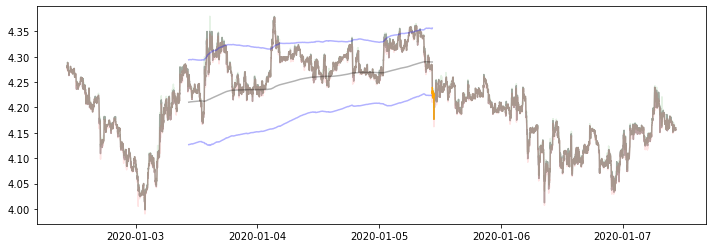

In [311]:
i+=1
item = events.index[i]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df.loc[item-pd.Timedelta(days=3):item+pd.Timedelta(days=2)].high, c="green", alpha=0.1)
ax.plot(df.loc[item-pd.Timedelta(days=3):item+pd.Timedelta(days=2)].close, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(days=3):item+pd.Timedelta(days=2)].low, c="red", alpha=0.1)

ax.plot(df.loc[item-pd.Timedelta(days=2):item].kc_upper, c="blue", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(days=2):item].kc_middle, c="black", alpha=0.3)
ax.plot(df.loc[item-pd.Timedelta(days=2):item].kc_lower, c="blue", alpha=0.3)

ax.plot(df.loc[item:events.loc[item].t1].close, c="orange", alpha=1)
# ax.axhline(df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="green", alpha=0.2)
# ax.axhline(-df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="red", alpha=0.2)


In [312]:
i

201

In [313]:
events.loc[events.index[i]]

ret                   -1.0
t1     2020-01-05 10:47:00
Name: 2020-01-05 10:27:00, dtype: object

In [314]:
df.loc[events.index[i]]

open             4.264000
high             4.272000
low              4.210000
close            4.239000
volume       35306.044000
kc_middle        4.289744
kc_upper         4.356588
kc_lower         4.222900
Name: 2020-01-05 10:27:00, dtype: float64

## Get metadata

In [1345]:
stats = ["v0", "k0", "s0", "v1", "v2", "k1", "k2", "s1", "s2", "t0", "t1", "t2", "k3", "k4", "k5",
         "k6", "k7", "v3"]

In [1395]:
def volume(df1, df2, df3):
    return sum(df1.volume)/sum(df2.volume)
def kc_mid(df1, df2, df3):
    return np.mean((df1.close-df1.kc_lower)/(df1.kc_upper-df1.kc_lower))
#     return np.mean((df1.close-df1.kc_lower)/(df1.kc_upper-df1.kc_lower))
def std_compare(df1, df2, df3):
    return np.std(df1.close)/df1.iloc[0].close
def v1(df1, df2, df3):
    return sum(df1.volume)/sum(df3.volume)
def v2(df1, df2, df3):
    return (np.std(df1.volume)-np.std(df2.volume))/df1.iloc[0].close
def k1(df1, df2, df3):
    return np.mean(df1.kc_upper-df1.kc_lower)/df1.iloc[0].close
def k2(df1, df2, df3):
    return np.mean(df2.kc_upper-df2.kc_lower)/df2.iloc[0].close
def s1(df1, df2, df3):
    return np.std(df2.close)/df2.iloc[0].close
def s2(df1, df2, df3):
    return np.std(df2.kc_upper-df2.kc_lower)/df2.iloc[0].close
def t0(df1, df2, df3):
    return df1.iloc[-1].kc_middle-df1.iloc[0].kc_middle
def t1(df1, df2, df3):
    return df2.iloc[-1].kc_middle-df2.iloc[0].kc_middle
def t2(df1, df2, df3):
    return df3.iloc[-1].kc_middle-df3.iloc[0].kc_middle
def k3(df1, df2, df3):
    return np.mean((df2.close-df2.kc_lower)/(df2.kc_upper-df2.kc_lower))
def k4(df1, df2, df3):
    return np.mean((df3.close-df3.kc_lower)/(df3.kc_upper-df3.kc_lower))
def k5(df1, df2, df3):
    return ((df1.kc_upper[-1]-df1.kc_lower[-1])-(df1.kc_upper[0]-df1.kc_lower[0]))/df1.iloc[0].close
def k6(df1, df2, df3):
    return ((df2.kc_upper[-1]-df2.kc_lower[-1])-(df2.kc_upper[0]-df2.kc_lower[0]))/df2.iloc[0].close
def k7(df1, df2, df3):
    return ((df3.kc_upper[-1]-df3.kc_lower[-1])-(df3.kc_upper[0]-df3.kc_lower[0]))/df3.iloc[0].close
def v3(df1, df2, df3):
    return sum(df1.loc[df1.index[-1]-pd.Timedelta(hours=12):].volume)/sum(df1.volume)

In [1396]:
funcs = [volume, kc_mid, std_compare, v1, v2, k1, k2, s1, s2, t0, t1, t2, k3, k4, k5,
         k6, k7, v3]

In [1397]:
e = get_kc_events(df, events, stats, funcs)

In [1398]:
e["ret"] = events.ret

In [1399]:
e.tail(3)

,v0,k0,s0,v1,v2,k1,k2,s1,s2,t0,t1,t2,k3,k4,k5,k6,k7,v3,ret
timestamp,,,,,,,,,,,,,,,,,,,
2021-11-04 15:15:00,0.295288,0.620842,0.011676,0.147368,-17557.653464,0.060671,0.052798,0.027332,0.009323,0.019855,0.064488,0.018919,0.657422,0.512746,-0.009246,0.006524,-0.018764,0.462372,-1.0
2021-11-06 11:05:00,0.231841,0.413523,0.007804,0.096219,-38837.995254,0.045882,0.051426,0.017245,0.007296,-0.009895,-0.000275,-0.006903,0.484845,0.483569,-0.004479,-0.012731,-0.003587,0.516838,1.0
2021-11-10 20:01:00,0.304599,0.722016,0.012095,0.208806,-14365.004708,0.075988,0.062475,0.051542,0.022249,0.047490,0.228632,0.201549,1.025924,0.695907,-0.008024,0.046416,0.016592,0.481466,1.0


## Analysis and testing

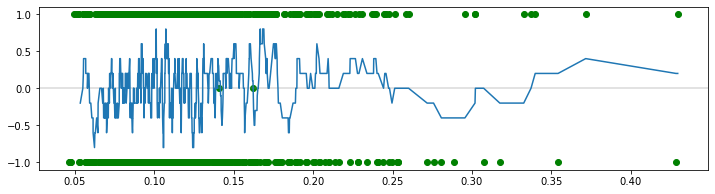

In [1423]:
x = e.v1
y = e.ret
fig, ax = plt.subplots(figsize=(12,3))
ax.scatter(x=x, y=y, c="green")
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 10))

In [1424]:
print(f"mean:{round(m(x), 4)}, std: {round(np.std(x), 4)}")

mean:0.1264, std: 0.0521


In [1402]:
def m(s):
    return np.mean(s)
def s(s):
    return np.std(s)
print(stats)

['v0', 'k0', 's0', 'v1', 'v2', 'k1', 'k2', 's1', 's2', 't0', 't1', 't2', 'k3', 'k4', 'k5', 'k6', 'k7', 'v3']


In [1403]:
i = -1

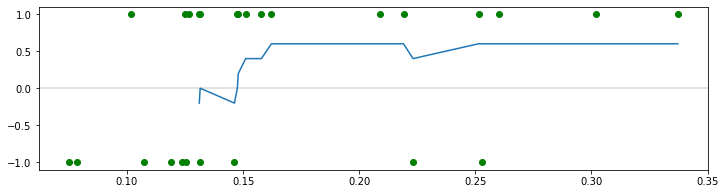

In [1421]:
i +=1
base = e[
        (e.t0>m(e.t0)+0.5*s(e.t0))\
#         & (e.v3>m(e.v3))\
#         & (e.k6>m(e.k6)+s(e.k6))\
#         & (e.k7>m(e.k7)+s(e.k7))\
        ]

base = e[(e.t0>-2*m(e.t0)) & (e.k3>1.5*m(e.k3))]

# x = base[stats[i]]
x = base.v1

y = base.ret
fig, ax = plt.subplots(figsize=(12,3))

ax.scatter(x=x, y=y, c="green")
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 10))

In [1422]:
print(f"{stats[i]}: mean:{round(m(e[stats[i]]), 4)}, std: {round(np.std(e[stats[i]]), 4)}")

k3: mean:0.4547, std: 0.3043


In [1416]:
y.value_counts()[1]/len(y)

0.5897435897435898

In [1319]:
events.reindex(x.index)

,ret,t1
timestamp,,
2021-01-04 10:17:00,1.0,2021-01-04 10:19:00
2021-02-10 12:40:00,1.0,2021-02-10 12:43:00
2021-03-20 23:09:00,-1.0,2021-03-21 00:02:00
2021-03-21 02:27:00,-1.0,2021-03-21 04:49:00
2021-05-07 22:36:00,1.0,2021-05-07 23:12:00
2021-06-04 01:17:00,1.0,2021-06-04 01:30:00
2021-06-04 05:37:00,-1.0,2021-06-04 07:20:00
2021-07-27 01:36:00,1.0,2021-07-27 10:28:00
2021-08-12 05:28:00,1.0,2021-08-12 05:41:00


## Combinations

- e[(e.v0<m(e.v0)) & (e.k0>1.2*m(e.k0)) & (e.s0>m(e.s0))] ?? e[(e.v0<m(e.v0)) & (e.k0>m(e.k0)+0.5*s(e.k0)) & (e.s0>m(e.s0))]
- e[(e.k1<2*m(e.k1)) & (e.s0<2*m(e.s0)) & (e.s1>1.5*m(e.s1))]
- e[(e.t0>-2*m(e.t0)) & (e.k3>1.5*m(e.k3))]
- e[
        (e.k5<m(e.k5)+2*s(e.k5))\
        & (e.k5>m(e.k5)-2*s(e.k5))\
        & (e.k6>m(e.k6)+s(e.k6))\
        & (e.k7>m(e.k7)+s(e.k7))\
        ]
- e[(e.t0>m(e.t0)+0.5*s(e.t0))]

In [ ]:
# base = e[(e.v0<m(e.v0)) & (e.k0>1.2*m(e.k0)) & (e.s0>m(e.s0))]
base = e[(e.t0>-2*m(e.t0))\
         & (e.k3>1.5*m(e.k3))\
#          & (e.s1>1.5*m(e.s1))
        ]
# base = e[(e.v0<m(e.v0)) & (e.k0>1.2*m(e.k0)) & (e.s0>m(e.s0))]

x = base.t2
y = base.ret
fig, ax = plt.subplots(figsize=(12,3))

ax.scatter(x=x, y=y, c="green")
ax.axhline(0, c="gray", alpha=0.3)

ax.plot(average_line(x, y, 10))